<a href="https://colab.research.google.com/github/kmrasmussen/cell_project/blob/main/Section_4_3_Zero_inflated_Poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ZIP

Standard vanilla VAE but with zero-inflated Poisson likelihood

In [ ]:
!pip install pyro-ppl

     |████████████████████████████████| 573kB 4.9MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pyro

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class CellDataset(Dataset):
  def __init__(self, numpy_matrix, batch_labels):
    self.X = torch.from_numpy(numpy_matrix)
    self.n_genes = self.X.shape[1]
    self.batch_labels = batch_labels.reshape(-1).astype(np.float32)
    self.batch_label_max = int(np.max(self.batch_labels))

    # Library sizes for each cell, mean and variance across cells
    self.cell_log_library_sizes = torch.sum(self.X, dim = 1)
    self.log_library_sizes_mean = self.cell_log_library_sizes.mean().item()
    self.log_library_sizes_var = self.cell_log_library_sizes.var().item()
    print('Library sizes mean', self.log_library_sizes_mean, 'var', self.log_library_sizes_var)
    
  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return {'x': self.X[idx], 'library_size': self.cell_log_library_sizes[idx], 'batch_number': self.batch_labels[idx]}

In [ ]:
X = np.load('/content/gdrive/My Drive/uni_archive/cell/immune_control_subsampled_alone.npy')
y = np.zeros(X.shape[0])

In [ ]:
dataset = CellDataset(X, y)
minibatch_size = 32
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [7000, 3000, 3019])
train_loader = DataLoader(train_set, batch_size=minibatch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=minibatch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=minibatch_size, shuffle=True)

Library sizes mean 545.81494140625 var 369664.1875


In [ ]:
torch.cuda.is_available()

True

In [ ]:
class ZIP_VAE_FORSOEG2(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super().__init__()
        
        # encoder part
        self.mu_1 = nn.Linear(x_dim, h_dim1)
        torch.nn.init.xavier_uniform_(self.mu_1.weight)
        self.mu_2 = nn.Linear(h_dim1, h_dim2)
        torch.nn.init.xavier_uniform_(self.mu_2.weight)
        self.mu_3 = nn.Linear(h_dim1, z_dim)
        torch.nn.init.xavier_uniform_(self.mu_3.weight)

        self.var_1 = nn.Linear(x_dim, h_dim1)
        torch.nn.init.xavier_uniform_(self.var_1.weight)
        self.var_2 = nn.Linear(h_dim1, h_dim2)
        torch.nn.init.xavier_uniform_(self.var_2.weight)
        self.var_3 = nn.Linear(h_dim1, z_dim)
        torch.nn.init.xavier_uniform_(self.var_3.weight)

        # decoder part
        self.dec_1 = nn.Linear(z_dim, h_dim2)
        #self.dec_2 = nn.Linear(h_dim2, h_dim1)
        self.dec_3 = nn.Linear(h_dim2, x_dim)

        self.dec_dropout_1 = nn.Linear(z_dim, h_dim2)
        #self.dec_2 = nn.Linear(h_dim2, h_dim1)
        self.dec_dropout_3 = nn.Linear(h_dim2, x_dim)
        
    def encoder(self, x):
        mu = F.relu(self.mu_1(x))
        #mu = F.relu(self.mu_2(mu))
        mu = self.mu_3(mu)

        log_var = F.relu(self.var_1(x))
        #log_var = F.relu(self.var_2(log_var))
        log_var = self.var_3(log_var)
        return mu, log_var # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.dec_1(z))
        #h = F.relu(self.dec_2(h))
        h = self.dec_3(h)
        #h = F.sigmoid(h)

        dropout = F.relu(self.dec_dropout_1(z))
        dropout = self.dec_dropout_3(dropout)
        return h, dropout
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        log_lambdas, dropout = self.decoder(z)
        return log_lambdas, dropout, mu, log_var

In [ ]:
def train(model, dataloader, optimizer, loss_function, kld_beta):
    model.train()
    
    total_train_loss = 0.
    running_loss = 0.
    running_recons_loss = 0.
    running_kld_loss = 0.
    for batch_idx, data in enumerate(dataloader):
            
        optimizer.zero_grad()

        x = data['x']
        if torch.cuda.is_available():
          x = x.cuda()
        log_lambdas, dropout, mu, log_var = model(x)
        loss, recons_loss, kld_loss = loss_function(log_lambdas, dropout, mu, log_var, x, kld_beta)
        #print('loss', loss)

        if loss > 1e10:
          print('Might want to skip this optimizing step')

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        running_loss += loss.item()
        running_recons_loss += recons_loss.item()
        running_kld_loss += kld_loss.item()
        #if batch_idx % 100 == 99:
        #    print('Running loss', np.round(running_loss / (100. * minibatch_size)))
        #    running_loss = 0.
    return total_train_loss / len(dataloader.dataset), running_recons_loss / len(dataloader.dataset), running_kld_loss / len(dataloader.dataset)

In [ ]:
def validate(model, dataloader, optimizer, loss_function, kld_beta):
    model.eval()
    
    total_val_loss = 0.
    running_loss = 0.
    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):

            x = data['x']
            if torch.cuda.is_available():
              x = x.cuda()
            log_lambdas, dropout, mu, log_var = model(x)
            loss, recons_loss, kld_loss = loss_function(log_lambdas, dropout, mu, log_var, x, kld_beta)
            
            total_val_loss += loss.item()
            running_loss += loss.item()
            #if batch_idx % 100 == 99:
            #    print('Running loss', np.round(running_loss / (100. * minibatch_size)))
            #    running_loss = 0.
    return total_val_loss / len(dataloader.dataset)

In [ ]:
def poisson_loss_function_pyro(recons_x, mu, log_var, x, kld_beta):
    log_lambdas = recons_x
    log_lambdas = torch.clamp(input = log_lambdas, min=-9, max = 9.)
    lambdas = torch.exp(log_lambdas) #+ 1.
    poisson_dist = pyro.distributions.Poisson(lambdas) #.to_event(1)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    log_probs = poisson_dist.log_prob(x)
    poisson_likelihood = log_probs.sum()
    elbo = None
    if kld_beta == 0.:
        elbo = poisson_likelihood
    else:
        elbo = poisson_likelihood - kld_beta * KLD
    loss = -elbo
    if torch.isnan(loss) or torch.isinf(loss):
        print('log lambdas', log_lambdas, torch.isnan(log_lambdas).sum())
        print('lambdas', lambdas, torch.isnan(log_lambdas).sum())
        print('log probs', log_probs, torch.isnan(log_lambdas).sum())
        raise Exception('NaN loss')
    return loss

In [ ]:
def zip_loss_function_pyro(log_lambdas, dropout, mu, log_var, x, kld_beta):
    log_lambdas = torch.clamp(input = log_lambdas, min=-9., max = 9.)
    dropout = torch.clamp(input = dropout, min=-10., max = 9.)
    lambdas = torch.exp(log_lambdas) #+ 1.
    dropout = torch.sigmoid(dropout)
    poisson_dist = pyro.distributions.zero_inflated.ZeroInflatedPoisson(dropout, lambdas) #pyro.distributions.Poisson(lambdas) #.to_event(1)
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    log_probs = poisson_dist.log_prob(x)
    poisson_likelihood = log_probs.sum()
    elbo = None
    if kld_beta == 0.:
        elbo = poisson_likelihood
    else:
        elbo = poisson_likelihood - kld_beta * KLD
    loss = -elbo
    if torch.isnan(loss) or torch.isinf(loss):
        print('log lambdas', log_lambdas, torch.isnan(log_lambdas).sum())
        print('lambdas', lambdas, torch.isnan(log_lambdas).sum())
        print('log probs', log_probs, torch.isnan(log_lambdas).sum())
        raise Exception('NaN loss')
    return loss, poisson_likelihood, kld_beta * KLD

In [ ]:
# build model
vae = ZIP_VAE_FORSOEG2(x_dim=dataset.n_genes, h_dim1= 512, h_dim2=256, z_dim=20)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters(), lr=0.00001)

n_epochs = 500
train_history = []
kld_history = []
recons_history = []
val_history = []
ready_to_activate_kld = False
activate_kld_after = 10
ready_to_activate_aggresive = False
for epoch in range(n_epochs):
    print('Epoch', epoch)
    kld_beta = 0.
    if ready_to_activate_kld:
        kld_beta = min(1.0, 0.1 * (epoch - activate_kld_after))
    print('kld beta:', kld_beta)
    train_loss, recons_loss, kld_loss = train(vae, train_loader, optimizer, zip_loss_function_pyro, kld_beta)
    print('train loss', train_loss, 'recons', recons_loss, 'kld', kld_loss)
    if train_loss < 1500. and ready_to_activate_kld == False:
      activate_kld_after = epoch
      #print('Ready for kld')
      ready_to_activate_kld = True
    if train_loss < 1000. and ready_to_activate_aggresive == False:
      ready_to_activate_aggresive = True
      print('Increasing learning rate')
      for param_group in optimizer.param_groups:
        param_group['lr'] = 0.0001
    val_loss = validate(vae, val_loader, optimizer, zip_loss_function_pyro, kld_beta)
    print('validation loss', val_loss)
    train_history.append(train_loss)
    val_history.append(val_loss)

Epoch 0
kld beta: 0.0
train loss 40214.10885379464 recons -40214.10885379464 kld nan
validation loss 6424.052330729167
Epoch 1
kld beta: 0.0
train loss 6152.296083705357 recons -6152.296083705357 kld nan
validation loss 5271.3016015625
Epoch 2
kld beta: 0.0
train loss 5234.671559709822 recons -5234.671559709822 kld nan
validation loss 4079.3010416666666
Epoch 3
kld beta: 0.0
train loss 4460.103142299107 recons -4460.103142299107 kld nan
validation loss 3882.20523046875
Epoch 4
kld beta: 0.0
train loss 4035.1161149553573 recons -4035.1161149553573 kld nan
validation loss 3499.2599375
Epoch 5
kld beta: 0.0
train loss 3871.894921875 recons -3871.894921875 kld nan
validation loss 3415.8796575520832
Epoch 6
kld beta: 0.0
train loss 3668.5162310267856 recons -3668.5162310267856 kld nan
validation loss 3272.8817994791666
Epoch 7
kld beta: 0.0
train loss 3558.487920200893 recons -3558.487920200893 kld nan
validation loss 3064.0797239583335
Epoch 8
kld beta: 0.0
train loss 3427.0477843191966 re

KeyboardInterrupt: ignored

In [ ]:
test_loss = validate(vae, test_loader, optimizer, zip_loss_function_pyro, kld_beta = 1.0)
print('Test loss', test_loss)

Test loss 614.5314942214931


In [ ]:
vae

ZIP_VAE_FORSOEG2(
  (mu_1): Linear(in_features=4000, out_features=512, bias=True)
  (mu_2): Linear(in_features=512, out_features=256, bias=True)
  (mu_3): Linear(in_features=512, out_features=20, bias=True)
  (var_1): Linear(in_features=4000, out_features=512, bias=True)
  (var_2): Linear(in_features=512, out_features=256, bias=True)
  (var_3): Linear(in_features=512, out_features=20, bias=True)
  (dec_1): Linear(in_features=20, out_features=256, bias=True)
  (dec_3): Linear(in_features=256, out_features=4000, bias=True)
  (dec_dropout_1): Linear(in_features=20, out_features=256, bias=True)
  (dec_dropout_3): Linear(in_features=256, out_features=4000, bias=True)
)

In [ ]:
train_history = np.array(train_history)

In [ ]:
train_history[165] = train_history[164]

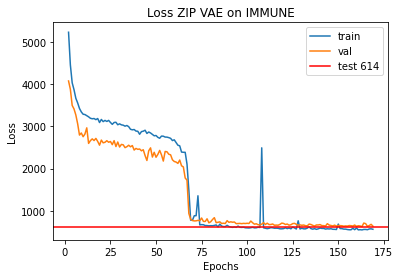

In [ ]:
plt.plot(np.arange(2,len(train_history)), train_history[2:], label='train')
plt.plot(np.arange(2,len(train_history)), val_history[2:], label='val')
plt.axhline(test_loss, c='red', label='test ' + str(int(test_loss)))
plt.title('Loss ZIP VAE on IMMUNE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/zip_vae_forsoeg2_aggressive_a_history.png')

In [ ]:
#torch.save(vae, '/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/outputs/zip_vae_forsoeg2_aggresive_a.pkl')

# Plot it all

In [ ]:
X_tensor = torch.tensor(X)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
if torch.cuda.is_available():
  X_tensor = X_tensor.cuda()

In [ ]:
X_encoded = vae.encoder(X_tensor.float())

In [ ]:
X_encoded_means = X_encoded[0]

In [ ]:
X_encoded_means.cpu()

tensor([[-0.8895,  0.2600,  0.5370,  ...,  1.5225,  1.8514,  0.9220],
        [ 0.0519, -1.2115, -0.0133,  ..., -2.4756, -2.0484,  0.8484],
        [ 0.5229,  0.2378,  1.3798,  ..., -2.0123, -0.8380,  3.6613],
        ...,
        [-0.1771, -1.4606, -0.6591,  ..., -0.2644, -1.4738, -1.1531],
        [ 0.9850,  0.7420,  0.5417,  ...,  0.4935,  1.3731,  0.0760],
        [ 2.2770, -0.1258,  0.4462,  ...,  0.7765, -0.4128,  0.9020]],
       grad_fn=<CopyBackwards>)

In [ ]:
X_encoded_means

tensor([[-0.8895,  0.2600,  0.5370,  ...,  1.5225,  1.8514,  0.9220],
        [ 0.0519, -1.2115, -0.0133,  ..., -2.4756, -2.0484,  0.8484],
        [ 0.5229,  0.2378,  1.3798,  ..., -2.0123, -0.8380,  3.6613],
        ...,
        [-0.1771, -1.4606, -0.6591,  ..., -0.2644, -1.4738, -1.1531],
        [ 0.9850,  0.7420,  0.5417,  ...,  0.4935,  1.3731,  0.0760],
        [ 2.2770, -0.1258,  0.4462,  ...,  0.7765, -0.4128,  0.9020]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
import umap
reducer = umap.UMAP()
X_encoded_umap = reducer.fit_transform(X_encoded_means.detach().cpu())

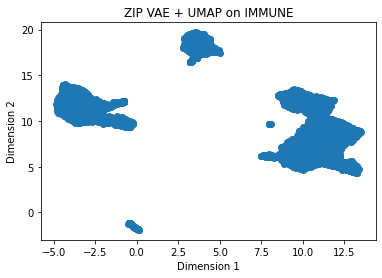

In [ ]:
plt.title('ZIP VAE + UMAP on IMMUNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.scatter(X_encoded_umap[:,0], X_encoded_umap[:,1])
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/Colab Cell Experiments/plots/zip_vae_forsoeg2_aggresive_a_umap.png')

## Generate cells

In [ ]:
Z_samples = torch.randn(1000, 20)

In [ ]:
Z_samples_umap_transformed = reducer.transform(Z_samples)

In [ ]:
absolute_zero = torch.zeros(1, 20)

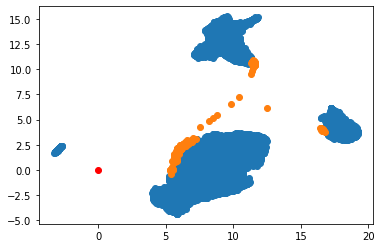

In [ ]:
plt.scatter(X_encoded_umap[:,0], X_encoded_umap[:,1])
plt.scatter(Z_samples_umap_transformed[:,0], Z_samples_umap_transformed[:,1])
plt.scatter(absolute_zero[:,0], absolute_zero[:,1], c='red')

In [ ]:
generated_decoded = None
with torch.no_grad():
    generated_decoded = vae.decoder(Z_samples)

In [ ]:
generated_decoded.shape

torch.Size([1000, 4000])